# SetFit for the classification of obligations and rights
In this workbook we will reflect on how to find hyperparameters for sentence classification and result evaluation in order to solve the task of classifying legal clauses as obligation and right.

# Setup

We need to install a series of dependencies based on the libraries we are going to use `setfit` and `optuna`. In addition, we import everything we need. Last, the connection to Hugging Face is made to load the trained model.

In [ ]:
## SetFit final version
!python -m pip install git+https://github.com/huggingface/setfit.git
!pip install setfit[optuna] matplotlib
!pip install umap-learn

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer, sample_dataset
from huggingface_hub import notebook_login
from umap import UMAP
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from typing import Dict
from optuna.visualization.matplotlib import plot_param_importances

In [ ]:
notebook_login()

# Load Dataset

We download our dataset, consisting of training, validation and test data.

In [3]:
dataset_id = "marmolpen3/sla-obligations-rights"
dataset = load_dataset(dataset_id)
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
test_dataset = dataset["test"]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# Hyperparameter search

For a hyperparameter lookup we need several changes to the normal training setup:

Instead of a model, we pass a model_init function, which can optionally use the hyperparameter dictionary.
We set up a function that defines the parameters for which we are interested in optimizing.

In [4]:
model_id = "sentence-transformers/paraphrase-mpnet-base-v2"

In [ ]:
def model_init(params):
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "liblinear")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained(model_id, **params)

In [ ]:
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 5),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        #"seed": trial.suggest_int("seed", 1, 40), default 42
        "num_iterations": trial.suggest_categorical("num_iterations", [10, 20]),
        #"max_iter": trial.suggest_int("max_iter", 50, 300),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
    }

In [ ]:
trainer = SetFitTrainer(
    train_dataset=eval_dataset,
    eval_dataset=train_dataset,
    model_init=model_init,
    loss_class=CosineSimilarityLoss,
    column_mapping={"text": "text", "label": "label"},
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=2)

[I 2023-08-01 06:31:23,645] A new study created in memory with name: no-name-2722c536-b070-49f1-a8ff-ee352ce183d8
Trial: {'learning_rate': 1.4933581854849503e-05, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20, 'solver': 'lbfgs'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 1
  Total optimization steps = 1500
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


[I 2023-08-01 06:37:38,214] Trial 0 finished with value: 0.8166666666666667 and parameters: {'learning_rate': 1.4933581854849503e-05, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8166666666666667.
Trial: {'learning_rate': 3.899631077779949e-05, 'num_epochs': 3, 'batch_size': 16, 'num_iterations': 20, 'solver': 'newton-cg'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 3
  Total optimization steps = 2250
  Total train batch size = 16


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/750 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2023-08-01 06:54:49,218] Trial 1 finished with value: 0.7866666666666666 and parameters: {'learning_rate': 3.899631077779949e-05, 'num_epochs': 3, 'batch_size': 16, 'num_iterations': 20, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.8166666666666667.


In [ ]:
best_run

BestRun(run_id='0', objective=0.8166666666666667, hyperparameters={'learning_rate': 1.4933581854849503e-05, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20, 'solver': 'lbfgs'}, backend=<optuna.study.study.Study object at 0x7fb2aaf40a00>)

In [ ]:
best_run.hyperparameters

{'learning_rate': 1.4933581854849503e-05,
 'num_epochs': 1,
 'batch_size': 8,
 'num_iterations': 20,
 'solver': 'lbfgs'}

<ipython-input-13-258fb16b29a9>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(best_run.backend);


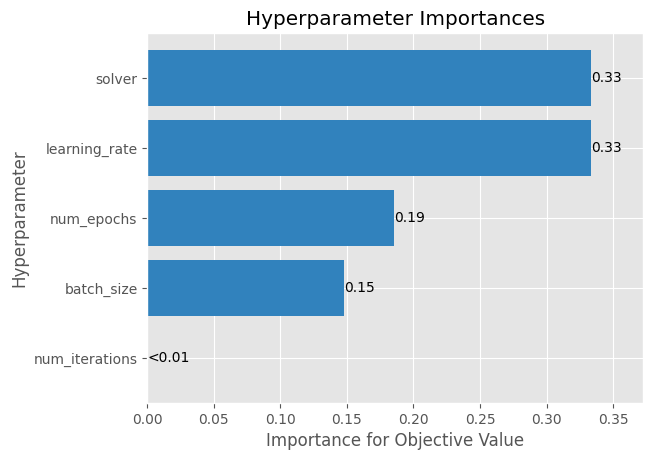

In [ ]:
plot_param_importances(best_run.backend);

# Fine-tuning and upload the model to the hub

Once the most appropriate parameters for solving the required task have been verified, we apply these values to train the model. We evaluate the values of the goodness-of-fit measures at each stage of training. Finally, the model is uploaded to the Hugging face repository to make it accessible.

In [71]:
def compute_metrics(y_pred, y_test) -> Dict[str, float]:
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1_score_micro = metrics.f1_score(y_test, y_pred, average='micro')
    precision = metrics.precision_score(y_test, y_pred, average="micro")
    recall = metrics.recall_score(y_test, y_pred, average="micro")

    results = [accuracy, f1_score_micro, precision, recall]
    return results

def get_list_metrics_values(dict):
  result = []
  for key, value in dict.items():
    res = [int(key)]
    res.extend(value)
    result.append(res)
  return result

In [72]:
model = SetFitModel.from_pretrained(model_id)
num_epochs = 5

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric=compute_metrics,
    num_iterations=20,
    learning_rate=1.4933581854849503e-05,
    batch_size=8,
    column_mapping={"text": "text", "label": "label"},
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [73]:
train_metrics, eval_metrics, train_embeddings, eval_embeddings = {}, {}, {}, {}

for epoch in range(num_epochs):
    trainer.train()
    train_metrics[epoch] = trainer.evaluate(train_dataset)
    eval_metrics[epoch] = trainer.evaluate()
    train_embeddings[epoch] = model.model_body.encode(train_dataset["text"])
    eval_embeddings[epoch] = model.model_body.encode(eval_dataset["text"])

Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 1
  Total optimization steps = 1500
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 1
  Total optimization steps = 1500
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 1
  Total optimization steps = 1500
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 1
  Total optimization steps = 1500
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 12000
  Num epochs = 1
  Total optimization steps = 1500
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
Applying column mapping to evaluation dataset
***** Running evaluation *****


Metrics results.

In [74]:
print("Train results")
v_train = get_list_metrics_values(train_metrics)
df_train = pd.DataFrame(v_train, columns=['Epoch', 'Accuracy', 'F1-micro', 'Precision', 'Recall'])
df_train.head()

Train results


,Epoch,Accuracy,F1-micro,Precision,Recall
0,0,1.0,1.0,1.0,1.0
1,1,1.0,1.0,1.0,1.0
2,2,1.0,1.0,1.0,1.0
3,3,1.0,1.0,1.0,1.0
4,4,1.0,1.0,1.0,1.0


In [75]:
print("Evaluation results")
v_eval = get_list_metrics_values(eval_metrics)
df_eval = pd.DataFrame(v_eval, columns=['Epoch', 'Accuracy', 'f1-micro', 'Precision', 'Recall'])
df_eval.head()

Evaluation results


,Epoch,Accuracy,f1-micro,Precision,Recall
0,0,0.730000,0.730000,0.730000,0.730000
1,1,0.746667,0.746667,0.746667,0.746667
2,2,0.706667,0.706667,0.706667,0.706667
3,3,0.743333,0.743333,0.743333,0.743333
4,4,0.736667,0.736667,0.736667,0.736667


Upload to the Hugging face repository the new model specifically trained to detect obligations and rights in agreement sentences.

In [76]:
finetuning_model_id = "marmolpen3/sla-obligations-rights"

In [ ]:
trainer.push_to_hub(finetuning_model_id)

# Analysis of the results
We observe the evolution in the training of the model through the graphical representation of the grouping of the embeddings according to their proximity. As well as the analysis of the confusion matrix for each of the available categories.

In [77]:
def print_3d_embeddings_per_epoch(embeddings, labels, title="Embeddings representation in last epoch"):
  X_scaled = MinMaxScaler().fit_transform(embeddings)
  umap_3d_components =  UMAP(n_components=3, metric="cosine").fit(X_scaled).embedding_

  result = pd.DataFrame(umap_3d_components, columns=['x', 'y', 'z'])
  result['labels'] = labels


  fig = px.scatter_3d(
    result, x='x', y='y', z='z', color=labels,
    size=[1]*len(embeddings), size_max=4, title=title
    )

  fig.update_traces(mode="markers", selector=dict(type='scatter3d'))
  fig.show()

def print_2d_embeddings_per_epoch(embeddings, labels, title="Embeddings representation in last epoch"):
  X_scaled = MinMaxScaler().fit_transform(embeddings)
  umap_2d_components = UMAP(n_components=2, metric="cosine").fit(X_scaled).embedding_

  result_2d = pd.DataFrame(umap_2d_components, columns=['x', 'y'])
  result_2d['labels'] = labels

  fig = px.scatter(
    result_2d, x='x', y='y', color=labels,
    size=[1]*len(embeddings), size_max=5, title=title
    )

  fig.update_traces(mode="markers", selector=dict(type='scatter2d'))
  fig.show()

def get_df_values(dict, dataset, dataset_type="Validation"):
  result_2d = pd.DataFrame()
  for key, value in dict.items():
    X_scaled = MinMaxScaler().fit_transform(value)
    umap_2d_components = UMAP(n_components=2, metric="cosine").fit(X_scaled).embedding_
    df = pd.DataFrame(umap_2d_components, columns=['x', 'y'])
    df['labels'] = dataset['label']
    df['epoch'] = int(key)
    df['dataset_type'] = dataset_type
    result_2d = pd.concat([result_2d, df])
  return result_2d

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    class_type = 'Obligation' if class_label == 'c0' else 'Right' if class_label == 'c1' else 'Neither' if class_label == 'c2' else class_label
    axes.set_title("Confusion Matrix for the class - " + class_type)

In [78]:
print_3d_embeddings_per_epoch(train_embeddings[list(train_embeddings)[-1]], train_dataset["label"], "Embeddings representation in the last epoch of training")

In [79]:
print_2d_embeddings_per_epoch(train_embeddings[list(train_embeddings)[-1]], eval_dataset["label"], "Embeddings representation in the last epoch of training")

In [80]:
print_3d_embeddings_per_epoch(eval_embeddings[list(eval_embeddings)[-1]], eval_dataset["label"], "Embeddings representation in the last epoch of validation")

In [81]:
print_2d_embeddings_per_epoch(eval_embeddings[list(eval_embeddings)[-1]], eval_dataset["label"], "Embeddings representation in the last epoch of validation")

In [82]:
df_train = get_df_values(train_embeddings, train_dataset, "Train")
df_eval = get_df_values(eval_embeddings, eval_dataset, "Validation")

In [91]:
df = pd.concat([df_train, df_eval])
fig = px.scatter(df, x="x", y="y", color="labels", facet_col="epoch", facet_row="dataset_type", title="Summary of embeddings representations in each training and validation epoch")
fig.show()

The confusion matrix has the following meaning:
*   True Negative (Top-Left Quadrant)
*   False Positive (Top-Right Quadrant)
*   False Negative (Bottom-Left Quadrant)
*   True Positive (Bottom-Right Quadrant)

True means that the values were accurately predicted, False means that there was an error or wrong prediction.

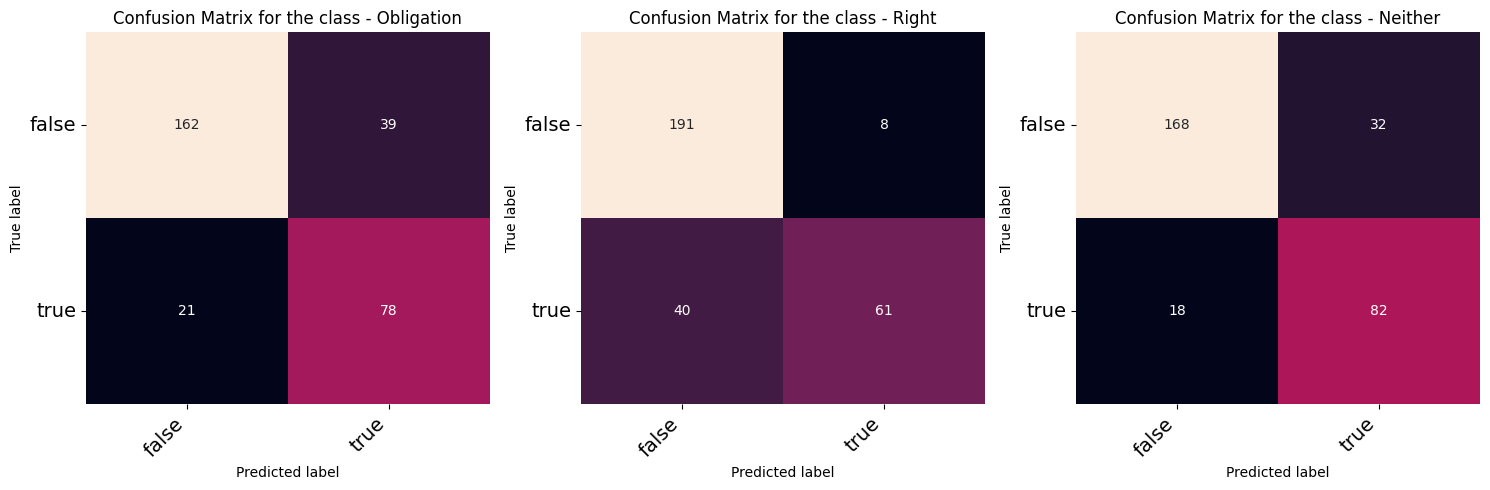

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
labels = ["".join("c" + str(i)) for i in range(0, 3)]
preds = model(eval_dataset["text"]).tolist()
confusion_matrix = metrics.multilabel_confusion_matrix(eval_dataset["label"], preds)

for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["false", "true"])
fig.tight_layout()
plt.show()

# Download model for test dataset inference
We download the trained model from the repository and observe the results obtained with the available test set. For this, the above metrics are evaluated and the embeddings are plotted.

In [85]:
modelt = SetFitModel.from_pretrained(finetuning_model_id)
preds_test = modelt(test_dataset['text'])

In [86]:
print("Test results")
v_test = compute_metrics(preds_test, test_dataset['label'])
df_test = pd.DataFrame([v_test], columns=['Accuracy', 'f1-micro', 'Precision', 'Recall'])
df_test.head()

Test results


,Accuracy,f1-micro,Precision,Recall
0,0.769231,0.769231,0.769231,0.769231


In [87]:
test_embeddings = model.model_body.encode(test_dataset["text"])

In [88]:
print_3d_embeddings_per_epoch(test_embeddings, test_dataset["label"], "Embeddings representation of the test set")

In [89]:
print_2d_embeddings_per_epoch(test_embeddings, test_dataset["label"], "Embeddings representation of the test set")

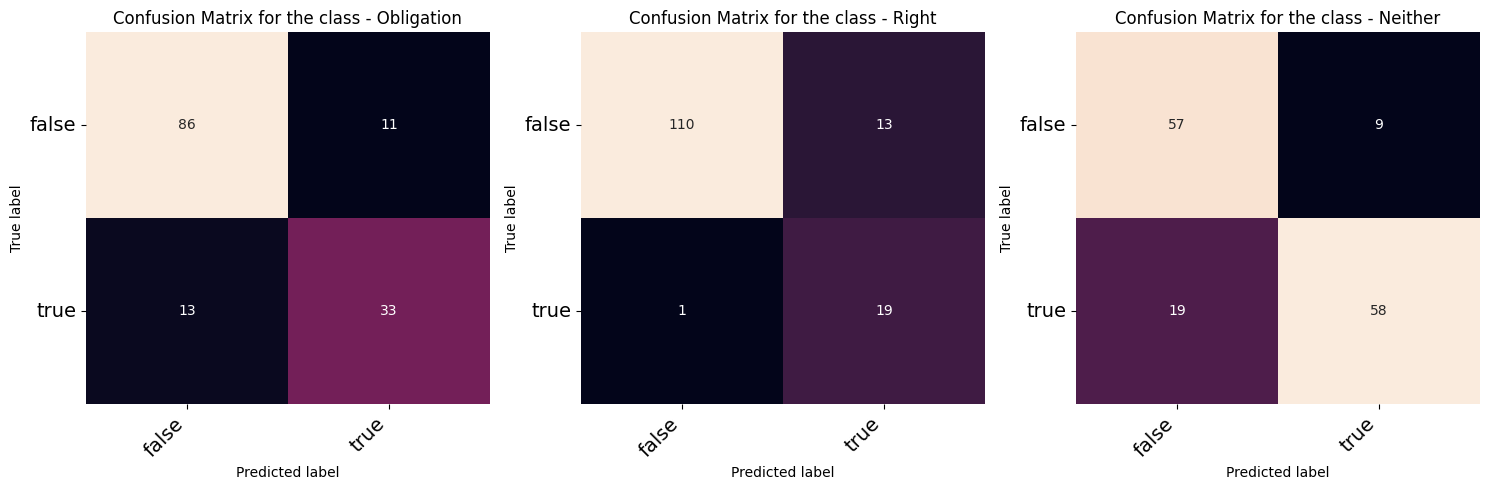

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
labels = ["".join("c" + str(i)) for i in range(0, 3)]
confusion_matrix = metrics.multilabel_confusion_matrix(test_dataset["label"], preds_test)

for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["false", "true"])
fig.tight_layout()
plt.show()